# Data Self-Driving Car Simulation

In [2]:
pip install tensorflow==2.17.0 opencv-python pandas scikit-learn matplotlib imgaug

   ---------------------------------------- 0.0/385.2 MB ? eta -:--:--
   ---------------------------------------- 1.0/385.2 MB 7.1 MB/s eta 0:00:54
   ---------------------------------------- 1.8/385.2 MB 5.0 MB/s eta 0:01:17
   ---------------------------------------- 2.6/385.2 MB 4.6 MB/s eta 0:01:24
   ---------------------------------------- 3.4/385.2 MB 4.4 MB/s eta 0:01:28
   ---------------------------------------- 4.5/385.2 MB 4.3 MB/s eta 0:01:30
    --------------------------------------- 5.2/385.2 MB 4.2 MB/s eta 0:01:31
    --------------------------------------- 6.0/385.2 MB 4.1 MB/s eta 0:01:32
    --------------------------------------- 6.8/385.2 MB 4.1 MB/s eta 0:01:33
    --------------------------------------- 7.6/385.2 MB 4.1 MB/s eta 0:01:33
    --------------------------------------- 8.7/385.2 MB 4.0 MB/s eta 0:01:34
    --------------------------------------- 9.2/385.2 MB 4.0 MB/s eta 0:01:34
   - -------------------------------------- 10.2/385.2 MB 4.0 MB/s eta 

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yolov5 7.0.14 requires huggingface-hub<0.25.0,>=0.12.0, but you have huggingface-hub 0.25.2 which is incompatible.

[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
# Imports
import os
import random
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import imgaug.augmenters as iaa

d:\anaconda3\Lib\site-packages\paramiko\pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from cryptography.hazmat.primitives.ciphers.algorithms in 48.0.0.
  "cipher": algorithms.TripleDES,
d:\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.Blowfish and will be removed from cryptography.hazmat.primitives.ciphers.algorithms in 45.0.0.
  "class": algorithms.Blowfish,
d:\anaconda3\Lib\site-packages\paramiko\transport.py:243: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from cryptography.hazmat.primitives.ciphers.algorithms in 48.0.0.
  "class": algorithms.TripleDES,


In [4]:
# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [5]:
# Dataset Loading and Merging
DATASET_DIRS = [
    "self_driving_car_dataset_jungle",
    "self_driving_car_dataset_make"
]

df_list = []
for folder in DATASET_DIRS:
    csv_path = os.path.join(folder, "driving_log.csv")
    if os.path.exists(csv_path):
        df_temp = pd.read_csv(csv_path, header=None)
        df_temp.columns = ['center', 'left', 'right', 'steering', 'throttle', 'brake', 'speed']
        for col in ['center', 'left', 'right']:
            df_temp[col] = df_temp[col].apply(lambda x: os.path.join(folder, "IMG", os.path.basename(str(x).strip())))
        df_list.append(df_temp)
    else:
        print(f"Warning: driving_log.csv not found in {folder}")

df = pd.concat(df_list, ignore_index=True)
print("Combined dataset shape:", df.shape)
print("Samples per dataset:", [len(d) for d in df_list])
df.head()

Combined dataset shape: (3930, 7)
Samples per dataset: [3930]


,center,left,right,steering,throttle,brake,speed
0,self_driving_car_dataset_make\IMG\center_2022_...,self_driving_car_dataset_make\IMG\left_2022_04...,self_driving_car_dataset_make\IMG\right_2022_0...,0.0,0.0,0,0.000013
1,self_driving_car_dataset_make\IMG\center_2022_...,self_driving_car_dataset_make\IMG\left_2022_04...,self_driving_car_dataset_make\IMG\right_2022_0...,0.0,0.0,0,0.000010
2,self_driving_car_dataset_make\IMG\center_2022_...,self_driving_car_dataset_make\IMG\left_2022_04...,self_driving_car_dataset_make\IMG\right_2022_0...,0.0,0.0,0,0.000008
3,self_driving_car_dataset_make\IMG\center_2022_...,self_driving_car_dataset_make\IMG\left_2022_04...,self_driving_car_dataset_make\IMG\right_2022_0...,0.0,0.0,0,0.000021
4,self_driving_car_dataset_make\IMG\center_2022_...,self_driving_car_dataset_make\IMG\left_2022_04...,self_driving_car_dataset_make\IMG\right_2022_0...,0.0,0.0,0,0.000014


In [6]:
# Helper Functions
def load_image(path):
    img = cv2.imread(path)
    if img is None:
        raise FileNotFoundError(f"Image not found: {path}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def preprocess_image(img, roi_crop=True, resize_shape=(66, 200)):
    if roi_crop:
        h = img.shape[0]
        img = img[60:h-25, :, :]
    img = cv2.resize(img, (resize_shape[1], resize_shape[0]))
    img = img.astype(np.float32) / 255.0 - 0.5
    return img

In [7]:
# Create Samples (Center, Left, Right)
samples = []
correction = 0.25

for idx, row in df.iterrows():
    center_path = row['center']
    left_path = row['left']
    right_path = row['right']
    steering = float(row['steering'])
    samples.append((center_path, steering))
    samples.append((left_path, steering + correction))
    samples.append((right_path, steering - correction))

print("Total samples (center+left+right):", len(samples))

Total samples (center+left+right): 11790


In [8]:
# Split Train and Validation Sets
random.shuffle(samples)
train_samples, val_samples = train_test_split(samples, test_size=0.2, random_state=SEED)
print("Train samples:", len(train_samples), "Validation samples:", len(val_samples))

Train samples: 9432 Validation samples: 2358


In [9]:
# Data Generator with Augmentation
aug_seq = iaa.Sequential([
    iaa.Sometimes(0.5, iaa.Affine(translate_percent={"x": (-0.1, 0.1), "y": (-0.05, 0.05)}, rotate=(-5,5))),
    iaa.Sometimes(0.5, iaa.Multiply((0.6, 1.4))),
    iaa.Sometimes(0.5, iaa.GaussianBlur(sigma=(0.0, 1.0))),
])

def batch_generator(samples, batch_size=32, is_training=True):
    num_samples = len(samples)
    while True:
        random.shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch = samples[offset:offset+batch_size]
            images = []
            angles = []
            for img_path, angle in batch:
                try:
                    img = load_image(img_path)
                except FileNotFoundError:
                    continue
                if is_training:
                    if random.random() < 0.5:
                        img = cv2.flip(img, 1)
                        angle = -angle
                    img = aug_seq(image=img)
                img = preprocess_image(img)
                images.append(img)
                angles.append(angle)
            if len(images) == 0:
                continue
            X = np.array(images)
            y = np.array(angles, dtype=np.float32)
            yield X, y


In [10]:
# Model Definition (NVIDIA Architecture)
def nvidia_model(input_shape=(66, 200, 3)):
    model = models.Sequential()
    model.add(layers.Input(shape=input_shape))
    model.add(layers.Conv2D(24, (5,5), strides=(2,2), activation='relu'))
    model.add(layers.Conv2D(36, (5,5), strides=(2,2), activation='relu'))
    model.add(layers.Conv2D(48, (5,5), strides=(2,2), activation='relu'))
    model.add(layers.Conv2D(64, (3,3), activation='relu'))
    model.add(layers.Conv2D(64, (3,3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(50, activation='relu'))
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(1))
    return model

model = nvidia_model()
model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss='mse')
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 31, 98, 24)     │         1,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 47, 36)     │        21,636 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 5, 22, 48)      │        43,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 3, 20, 64)      │        27,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 1, 18, 64)      │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │       115,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           510 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 252,219 (985.23 KB)

 Trainable params: 252,219 (985.23 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Training
batch_size = 64
train_gen = batch_generator(train_samples, batch_size=batch_size, is_training=True)
val_gen = batch_generator(val_samples, batch_size=batch_size, is_training=False)

steps_per_epoch = max(1, len(train_samples) // batch_size)
validation_steps = max(1, len(val_samples) // batch_size)

checkpoint_path = "model_checkpoint.h5"
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min'),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
]

history = model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=30,
    validation_data=val_gen,
    validation_steps=validation_steps,
    callbacks=callbacks
)

Epoch 1/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.0573

147/147 ━━━━━━━━━━━━━━━━━━━━ 311s 2s/step - loss: 0.0540 - val_loss: 0.0366
Epoch 2/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 901ms/step - loss: 0.0437

147/147 ━━━━━━━━━━━━━━━━━━━━ 140s 962ms/step - loss: 0.0411 - val_loss: 0.0261
Epoch 3/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step - loss: 0.0367

147/147 ━━━━━━━━━━━━━━━━━━━━ 67s 460ms/step - loss: 0.0352 - val_loss: 0.0253
Epoch 4/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - loss: 0.0320

147/147 ━━━━━━━━━━━━━━━━━━━━ 61s 420ms/step - loss: 0.0315 - val_loss: 0.0238
Epoch 5/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 885ms/step - loss: 0.0286

147/147 ━━━━━━━━━━━━━━━━━━━━ 161s 1s/step - loss: 0.0286 - val_loss: 0.0218
Epoch 6/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.0260

147/147 ━━━━━━━━━━━━━━━━━━━━ 622s 4s/step - loss: 0.0269 - val_loss: 0.0208
Epoch 7/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 0.0272

147/147 ━━━━━━━━━━━━━━━━━━━━ 738s 5s/step - loss: 0.0265 - val_loss: 0.0205
Epoch 8/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 660s 5s/step - loss: 0.0248 - val_loss: 0.0212
Epoch 9/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 431s 3s/step - loss: 0.0245 - val_loss: 0.0206
Epoch 10/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.0238

147/147 ━━━━━━━━━━━━━━━━━━━━ 178s 1s/step - loss: 0.0240 - val_loss: 0.0198
Epoch 11/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 207s 1s/step - loss: 0.0235 - val_loss: 0.0205
Epoch 12/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 234s 2s/step - loss: 0.0232 - val_loss: 0.0204
Epoch 13/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.0221

147/147 ━━━━━━━━━━━━━━━━━━━━ 198s 1s/step - loss: 0.0232 - val_loss: 0.0189
Epoch 14/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 316s 2s/step - loss: 0.0222 - val_loss: 0.0209
Epoch 15/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 197s 1s/step - loss: 0.0219 - val_loss: 0.0197
Epoch 16/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 165s 1s/step - loss: 0.0225 - val_loss: 0.0192
Epoch 17/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 172s 1s/step - loss: 0.0215 - val_loss: 0.0209
Epoch 18/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.0217

147/147 ━━━━━━━━━━━━━━━━━━━━ 179s 1s/step - loss: 0.0216 - val_loss: 0.0186
Epoch 19/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 164s 1s/step - loss: 0.0213 - val_loss: 0.0198
Epoch 20/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.0212

147/147 ━━━━━━━━━━━━━━━━━━━━ 418s 3s/step - loss: 0.0213 - val_loss: 0.0177
Epoch 21/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 410s 3s/step - loss: 0.0208 - val_loss: 0.0197
Epoch 22/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.0220

147/147 ━━━━━━━━━━━━━━━━━━━━ 210s 1s/step - loss: 0.0211 - val_loss: 0.0168
Epoch 23/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - loss: 0.0207 - val_loss: 0.0194
Epoch 24/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 183s 1s/step - loss: 0.0210 - val_loss: 0.0181
Epoch 25/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 159s 1s/step - loss: 0.0201 - val_loss: 0.0175
Epoch 26/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 355s 2s/step - loss: 0.0200 - val_loss: 0.0183
Epoch 27/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 540s 4s/step - loss: 0.0206 - val_loss: 0.0185


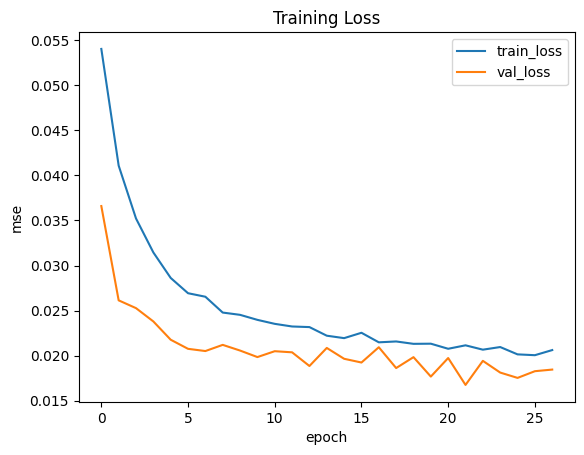

Saved model to steering_model.h5


In [12]:
# Evaluation and Saving
plt.figure()
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('mse')
plt.title('Training Loss')
plt.show()

model.save("steering_model.h5")
print("Saved model to steering_model.h5")

In [13]:
# Validation Performance Check
val_gen_eval = batch_generator(val_samples, batch_size=64, is_training=False)
eval_steps = min(50, validation_steps)
mse_vals = []
for _ in range(eval_steps):
    Xv, yv = next(val_gen_eval)
    ypred = model.predict(Xv)
    mse_vals.append(np.mean((ypred.flatten() - yv)**2))
print("Validation MSE (avg over {} batches): {:.6f}".format(eval_steps, np.mean(mse_vals)))

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 237ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 449ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 211ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 514ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step   
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 328ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 358ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 252ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 234ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 

In [14]:
# Prediction Example
def predict_steering(image_path, model_path="steering_model.h5"):
    img = load_image(image_path)
    img = preprocess_image(img)
    X = np.expand_dims(img, axis=0)
    model_local = tf.keras.models.load_model(model_path)
    steering = float(model_local.predict(X)[0][0])
    return steering

# Example:
# print(predict_steering("self_driving_car_dataset_jungle/IMG/center_2021_01_01_12_00_00_000.jpg"))

print("Training complete. Model ready for inference.")

Training complete. Model ready for inference.
